# Gradient checking  

Welcome to the final assignment for this week! In this assignment you will learn to implement and use gradient checking.

For this purpose we are going to keep improve The previously built deep neural network model from intialization division. The model structure consists of four layers with with the following number of neurons ordinally [20,7,5,1] with the first three activation functions being relu while the output is activation is sigmoid. In addition, we will be employing the cat-VS-noncat image classification problem in our implematation.



**Tutorial plan**

In this tutorial we are going to illustrate:

1. 1-dimensional gradient checking
2. N-dimensional gradient checking


**Note**

As we said previously, we win not implemnt the gradient checking during the training phase as checking the gradints is a costy operation, but rather, we are going to design it as aseparate function to debug our model after finishing training.

Let's get start.

## How does gradient checking work?

Backpropagation computes the gradients $\frac{\partial J}{\partial \theta}$, where $\theta$ denotes the parameters of the model. $J$ is computed using forward propagation and your loss function.

Because forward propagation is relatively easy to implement, you're confident you got that right, and so you're almost 100% sure that you're computing the cost $J$ correctly. Thus, you can use your code for computing $J$ to verify the code for computing $\frac{\partial J}{\partial \theta}$.

Let's look back at the definition of a derivative (or gradient): $$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

If you're not familiar with the "$\displaystyle \lim_{\varepsilon \to 0}$" notation, it's just a way of saying "when $\varepsilon$ is really really small."

We know the following:

* $\frac{\partial J}{\partial \theta}$ is what you want to make sure you're computing correctly.
* You can compute $J(\theta + \varepsilon)$ and $J(\theta - \varepsilon)$ (in the case that $\theta$ is a real number), since you're confident your implementation for $J$ is correct.

Lets use equation (1) and a small value for $\varepsilon$ to verify that your code for computing $\frac{\partial J}{\partial \theta}$ is correct!


# Related packages importing

In [827]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from PIL import Image
from scipy import ndimage
os.chdir('../utils')
from lr_utils import load_dataset
from helpers import activation_fun, act_derivative, data_generator
from time import time

# Data preparation

In [721]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 1. It's a cat picture.


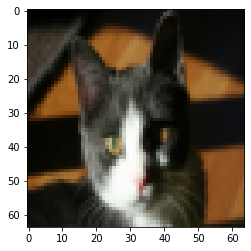

In [722]:
index = 19
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [723]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [724]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# Neural network and gradient checking  

All related functions of neural network model we prviously implemented are wrapped together in a python class for sake of implemetation simplicity.
Our target functions are:

1. dict2vec(): a function that takes a parameters dictionary and return a vector out of it.
2. vec2dict(): the inverse function of the previous one.
3. grads2vec(): a function that takes a gradients dictionary and return a vector out of it.
4. G=fradient_check: a function that check weather there is a difference between the actual gradients and their approximation. 

Thus, we are going to reimplement them separately and then plug them into the class to perform our expriments. Lets get start.

## 1-dimensional gradient checking  

Consider a 1D linear function $J(\theta) = \theta x$. The model contains only a single real-valued parameter $\theta$, and takes $x$ as input.

You will implement code to compute $J(.)$ and its derivative $\frac{\partial J}{\partial \theta}$. You will then use gradient checking to make sure your derivative computation for $J$ is correct.

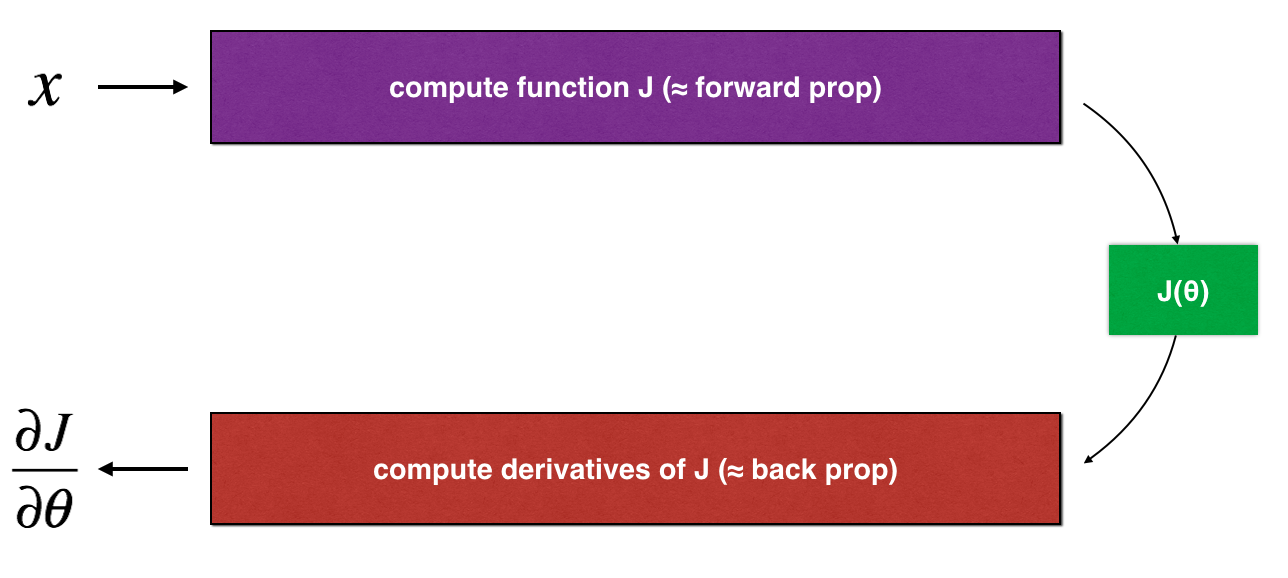  

The diagram above shows the key computation steps: First start with $x$, then evaluate the function $J(x)$ ("forward propagation"). Then compute the derivative $\frac{\partial J}{\partial \theta}$ ("backward propagation").

**Exercise1**: implement "forward propagation" and "backward propagation" for this simple function. I.e., compute both $J(.)$ ("forward propagation") and its derivative with respect to $\theta$ ("backward propagation"), in two separate functions.

**Exercise2**:implement the backward propagation step (derivative computation) of Figure 1. That is, compute the derivative of $J(\theta) = \theta x$ with respect to $\theta$. To save you from doing the calculus, you should get $dtheta = \frac { \partial J }{ \partial \theta} = x$.

In [725]:
def simple_forward_prob(x, theta):
    J = np.dot(theta,x)
    return J

In [726]:
simple_forward_prob(2,4)

8

In [727]:
def simple_backward_prop(x,theta):
    dtheta = x
    return dtheta

In [728]:
simple_backward_prop(2,4)

2



**Exercise3**: To show that the backward_propagation() function is correctly computing the gradient $\frac{\partial J}{\partial \theta}$, let's implement gradient checking.

**Instructions**:

* First compute "gradapprox" using the formula above (1) and a small value of $\varepsilon$. Here are the Steps to follow:
    1. $\theta^{+} = \theta + \varepsilon$
    2. $\theta^{-} = \theta - \varepsilon$
    3. $J^{+} = J(\theta^{+})$
    4. $J^{-} = J(\theta^{-})$
    5. $gradapprox = \frac{J^{+} - J^{-}}{2 \varepsilon}$
* Then compute the gradient using backward propagation, and store the result in a variable "grad"
* Finally, compute the relative difference between "gradapprox" and the "grad" using the following formula: $$ difference = \frac {\mid\mid grad - gradapprox \mid\mid_2}{\mid\mid grad \mid\mid_2 + \mid\mid gradapprox \mid\mid_2} \tag{2}$$ 
    You will need 3 Steps to compute this formula:
    1. compute the numerator using np.linalg.norm(...)
    2. compute the denominator. You will need to call np.linalg.norm(...) twice.
    3. divide them.
* If this difference is small (say less than $10^{-7}$), you can be quite confident that you have computed your gradient correctly. Otherwise, there may be a mistake in the gradient computation.



In [729]:
def simple_gradient_check(x, theta, ebsilon=1e-7):
    
    theta_plus = theta + ebsilon
    theta_minus = theta - ebsilon
    J_plus = simple_forward_prob(x,theta_plus)
    J_minus = simple_forward_prob(x,theta_minus)
    grad_approx = (J_plus - J_minus)/(2*ebsilon)
    
    grad = simple_backward_prop(x,theta)
    
    numerator = np.linalg.norm(grad - grad_approx)                      
    denominator = np.linalg.norm(grad) + np.linalg.norm(grad_approx)
    difference = numerator / denominator                               
    
    if difference < 1e-7:
        print("The gradient is correct!")
    else:
        print("The gradient is wrong!")
    
    return difference

In [730]:
difference = simple_gradient_check(2, 4)
print("difference = " + str(difference))

The gradient is correct!
difference = 2.919335883291695e-10


## N-dimensional gradient checking  

Now, in the more general case, your cost function $J$ has more than a single 1D input. When you are training a neural network, $\theta$ actually consists of multiple matrices $W^{[l]}$ and biases $b^{[l]}$! It is important to know how to do a gradient check with higher-dimensional inputs. Let's do it!  

The following figure describes the forward and backward propagation of your model.  
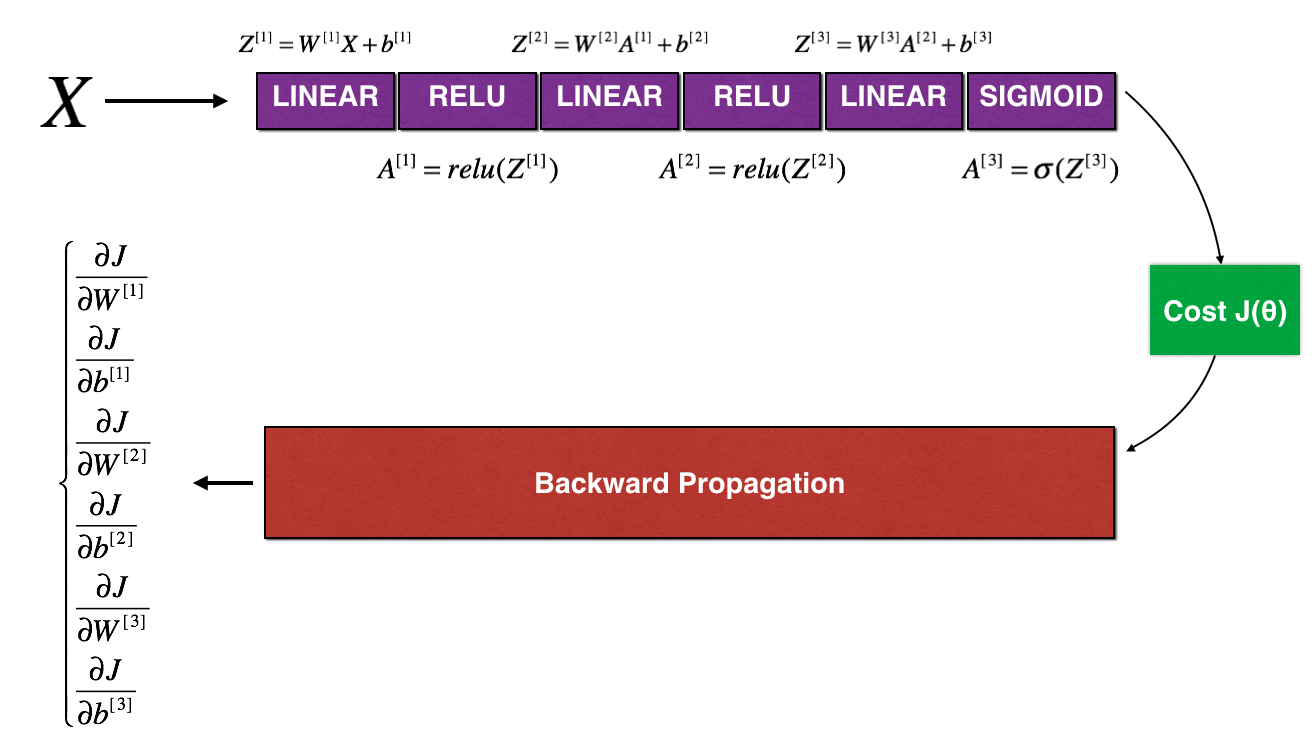  

To implement the gradient checking for our model we will need to reach to the following values:

1. The model parameters after completeing Forward propagation cycle from frorward_prob() function.
2. the cost function value from compute_cost() function.
3. the gradient values from backward_prop() function.


## How does gradient checking work for n-dimensions?  

As in 1) and 2), you want to compare "gradapprox" to the gradient computed by backpropagation. The formula is still:
$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

However, $\theta$ is not a scalar anymore. It is a dictionary called "parameters".Thus, We need to implement a function that converts the **parameters** dictionary into a vector. It converts the "parameters" dictionary into a vector called "values", obtained by reshaping all parameters (W1, b1, W2, b2,.... WL, bL) into vectors and concatenating them.In addition, we need an inverse function that which outputs back the "parameters" dictionary. We also need to convert the "gradients" dictionary into a vector called "grad" so that we need to a function to do so.  

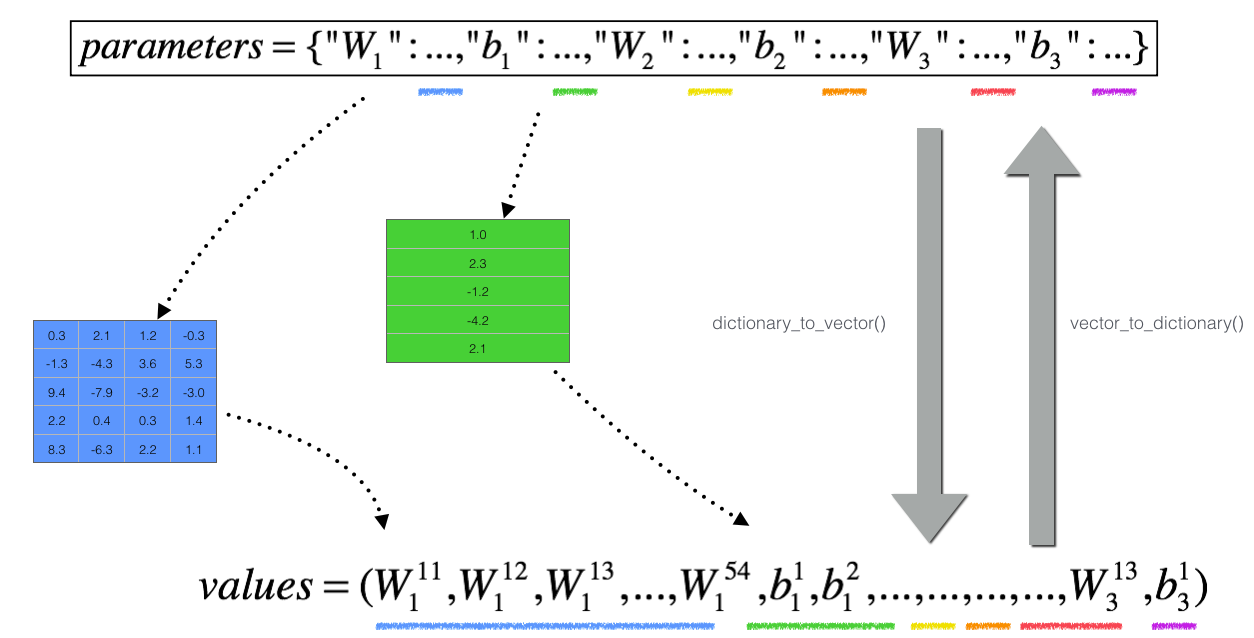  

**Exercise4**: Implement gradient_check() function.

**Instructions**: Here is pseudo-code that will help you implement the gradient check.

For each i in num_parameters:

* To compute J_plus[i]:
    1. Set $\theta^{+}$ to np.copy(parameters_values)  
    2. Set $\theta^{+}_i$ to $\theta^{+}_i + \varepsilon$  
    3. Calculate $J^{+}_i$ using to forward_propagation_n(x, y, vector_to_dictionary($\theta^{+}$ )).  
* To compute J_minus[i]: do the same thing with $\theta^{-}$  
* Compute $gradapprox[i] = \frac{J^{+}_i - J^{-}_i}{2 \varepsilon}$  

Thus, you get a vector gradapprox, where gradapprox[i] is an approximation of the gradient with respect to parameter_values[i]. You can now compare this gradapprox vector to the gradients vector from backpropagation. Just like for the 1D case (Steps 1', 2', 3'), compute: $$ difference = \frac {\| grad - gradapprox \|_2}{\| grad \|_2 + \| gradapprox \|_2 } \tag{3}$$

Let's get it fired

In [731]:
def dict2vec(paramaters):
    
    shapes = {}
    count = 0
    
    for key in paramaters.keys():
        new_vec =  np.reshape(paramaters[key],(-1,1))
        shapes[key] = paramaters[key].shape
        if count == 0:
            theta = new_vec
        else:
            theta = np.concatenate((theta,new_vec), axis = 0)
        count += 1
    return theta, shapes
    

In [732]:
def vec2dict(theta,shapes):
    
    parameters = {}
    start = 0
       
    for key in shapes.keys():
        
        end = start + shapes[key][0] * shapes[key][1] 
        
        parameters[key] = theta[start:end].reshape((shapes[key][0],shapes[key][1]))

        start = end
    
    return parameters

In [733]:
def grads2vec(grads):

    count = 0
    
    for key in grads.keys():
        new_vec =  np.reshape(grads[key],(-1,1))

        if count == 0:
            theta = new_vec
        else:
            theta = np.concatenate((theta,new_vec), axis = 0)
        count += 1
    return theta

In [782]:
    def gradient_check(X,Y,parameters, grads,ebsilon=1e-7):
    
        parameters_vec, shapes = dict2vec(parameters)
        gradient_vec = grads2vec(grads)
        parameters_num = parameters_vec.shape[0]
        J_plus = np.zeros((parameters_num,1))
        J_minus = np.zeros((parameters_num,1))
        grad_approx = np.zeros((parameters_num,1))
    
        for i in range(parameters_num):
            # positive side computations
            theta_plus = np.copy(parameters_vec)
            theta_plus[i][0] = theta_plus[i][0] + ebsilon
            cache = forward_prop(X,vec2dict(theta_plus,shapes))
        
            # Acounting for L2 regularization application
            if lambd:
                J_plus[i] = compute_L2cost(cache, vec2dict(theta_plus,shapes))
            else:
                J_plus[i] = compute_cost(cache)
        
            # negative side computations
            theta_minus = np.copy(parameters_vec)
            theta_minus[i][0] = theta_minus[i][0] - ebsilon
            cache = forward_prop(X,vec2dict(theta_minus,shapes))
        
            # Acounting for L2 regularization application
            if self.lambd:
                J_minus[i] = compute_L2cost(cache, vec2dict(theta_minus,shapes))
            else:
                J_minus[i] = compute_cost(cache)    
            
            grad_approx[i] = (J_plus[i] - J_minus[i]) / (2 * self.ebsilon)
        
        numerator = np.linalg.norm(gradient_vec - grad_approx)                               
        denominator = np.linalg.norm(gradient_vec) + np.linalg.norm(grad_approx)        
        difference = numerator / denominator                                                    
    
        if difference > 1e-7:
            print("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")            
        
        

In [825]:
class DeepNeuralNet:
    
    xtr, ytr, xts, yts = data_generator()

    def __init__(self, 
                 X=xtr,
                 Y=ytr,
                 initialization = 'he',
                 activation_order= ['relu','relu','sigmoid'], 
                 layer_dims = [4,3,2,1], 
                 num_iterations = 1000, 
                 learning_rate =.005, 
                 print_cost = True,
                 keep_prob = 1,
                 lambd = 0,
                 ebsilon=1e-7,
                 random_state =241):
        
        self.X = X
        self.Y = Y
        self.initialization = initialization
        self.layer_dims = layer_dims
        self.activation_order = activation_order
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.print_cost = print_cost
        self.keep_prob = keep_prob
        self.lambd = lambd
        self.ebsilon = ebsilon
        self.random_state = random_state
    

    # parameters initiation
    def initialize_parameters(self):
        np.random.seed(self.random_state)
        parameters ={}
        L = len(self.layer_dims)
        for l in range(1,L):
            #Zero initialization
            
            if self.initialization == 'zeros':
                parameters['W'+ str(l)] =  np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
                parameters['b'+ str(l)] =  np.zeros((self.layer_dims[l],1))
        
            #random initialization
            elif self.initialization == 'random':
                parameters['W'+ str(l)] =  np.random.randn(self.layer_dims[l],self.layer_dims[l-1])
                parameters['b'+ str(l)] =  np.zeros((self.layer_dims[l],1))
        
            #he initialization
            elif self.initialization == 'he':
                parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l - 1]) \
                * np.sqrt(2 / self.layer_dims[l - 1])
                parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))
    
        return parameters


    def forward_prop(self,X,parameters):
        
        A_prev = X
        cache = {}
    
        for  l,activation in enumerate(self.activation_order):
        
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
       
            Z = np.dot(W,A_prev) + b
            A = activation_fun(Z,activation_type= activation)
        
            cache['Z' + str(l+1)]= Z
            cache['A' + str(l+1)]= A
        
            A_prev = A
    
        return cache
    
    
    def dropout_forward_prop(self, X, parameters):
        
        A_prev = X
        cache = {}
    
        for  l,activation in enumerate(self.activation_order):
        
            if  l != (len(list(enumerate(self.activation_order)))-1):
                W = parameters['W' + str(l+1)]
                b = parameters['b' + str(l+1)]
       
                Z = np.dot(W,A_prev) + b
                A = activation_fun(Z,activation_type= activation)
                
                #np.random.seed(self.random_state)
                D = np.random.rand(A.shape[0],A.shape[1])
                D = D < keep_prob
            
                A = A * D
                A = A / self.keep_prob
            
                cache['Z' + str(l+1)]= Z
                cache['A' + str(l+1)]= A
                cache['D' + str(l+1)]= D
        
                A_prev = A
            
            else:
                W = parameters['W' + str(l+1)]
                b = parameters['b' + str(l+1)]
       
                Z = np.dot(W,A_prev) + b
                A = activation_fun(Z,activation_type= activation)   
            
                cache['Z' + str(l+1)] = Z
                cache['A' + str(l+1)] = A
                
                A_prev = A            
    
        return cache
    

    def compute_cost(self, cache):
    
        AL = cache[(list(cache.keys())[-1])]
        m = self.Y.shape[1]
    
        cost = np.squeeze((-1/m)*(np.dot(self.Y,np.log(AL+1e-7).T)+ np.dot((1-self.Y),np.log(1-AL+1e-7).T)))
        assert(cost.shape == ())
    
        return cost
    
    
    def compute_L2cost(self,cache, parameters):
    
        AL = cache[(list(cache.keys())[-1])]
        m = self.Y.shape[1]
        weights = {}
        L2_cost = 0 
    
        regular_cost = np.squeeze((-1/m)*(np.dot(self.Y,np.log(AL+1e-7).T)+ np.dot((1-self.Y),np.log(1-AL+1e-7).T)))
    
        for key, val in  parameters.items():
        
            if 'W' in key:
                weights[key] = val
                L2_cost += np.sum(np.square(weights[key]))
    
        L2_cost = (self.lambd/2*m) * L2_cost
    
        cost = regular_cost + L2_cost
    
        assert(cost.shape == ())
    
        return cost
    

    def backward_prop(self,parameters,cache):
    
        AL = cache['A'+str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
        
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T)
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
            dA = np.dot(W.T,dZ)
        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads
    
    def L2_backward_prop(self,parameters,cache):
    
        AL = cache['A'+str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
        
            dZ = dA * act_derivative(Z, activation_type= activation)
            dW = (1/m) * np.dot(dZ,A_prev.T) + (self.lambd/m) * W
            db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
            dA = np.dot(W.T,dZ)
        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads 
    
    
    def dropout_backward_prop(self,parameters,cache):
    
        AL = cache['A' + str(len(self.activation_order))]
        grads = {}
        dA =  - (np.divide(self.Y, AL) - np.divide(1 - self.Y, 1 - AL))
        m = self.Y.shape[1]
    
        for l, activation in reversed(list(enumerate(self.activation_order))):
        
            Z = cache['Z' + str(l+1)]
        
            if l == 0:
                A_prev = self.X
            else:
                A_prev = cache['A' + str(l)]
            
            W = parameters['W' + str(l+1)]
            
            
            if l == (len(self.activation_order)-1):
                dZ = dA * act_derivative(Z, activation_type= activation)
                dW = (1/m) * np.dot(dZ,A_prev.T)
                db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
                dA = np.dot(W.T,dZ)

            else:
                dZ = dA * act_derivative(Z, activation_type= activation)
                dW = (1/m) * np.dot(dZ,A_prev.T)
                db =  (1/m) * np.sum(np.dot(dZ, A_prev.T), axis = 1, keepdims =True)
                              
                
                D = cache['D'+ str(l+1)]
                dA = dA * D
                dA = dA/self.keep_prob
                dA = np.dot(W.T,dZ)  

        
            grads['dW'+ str(l+1)] = dW
            grads['db'+ str(l+1)] = db
    
        return grads
    
    

    def optimize(self,parameters, grads):
    
        L = int(len(grads)/2)+1
    
        for l in range(1,L):
        
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
        
            dW = grads['dW' + str(l)]
            db = grads['db' + str(l)]
        
            parameters['W' + str(l)] = W - self.learning_rate * dW
            parameters['b' + str(l)] = b - self.learning_rate * db
    
        return parameters


    def fit(self):
        costs = []
        global parameters
        global grads
        parameters = self.initialize_parameters()

        for i in range(self.num_iterations):
            
            if self.keep_prob == 1:
                cache = self.forward_prop(self.X,parameters)
            elif self.keep_prob < 1:
                cache = self.dropout_forward_prop(self.X, parameters)
                
            if self.lambd == 0:    
                cost = self.compute_cost(cache)
            else:
                cost = self.compute_L2cost(cache, parameters)
            
            assert(self.keep_prob == 1 or self.lambd == 0)
            
            if self.keep_prob == 1 and self.lambd == 0:
                grads = self.backward_prop(parameters,cache)
            elif self.keep_prob < 1:
                grads = self.dropout_backward_prop(parameters, cache)
            elif self.lambd !=0:
                grads = self.L2_backward_prop(parameters,cache)
        
            parameters = self.optimize(parameters,grads)
        
            if self.print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                costs.append(cost)
        
        # plot the loss
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per thosands)')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
        
        
        

    def predict(self, X=xts,Y=yts):
    
        m = X.shape[1]
        p = np.zeros((1,m))
    
        # Forward propagation
        cache = self.forward_prop(X,parameters)
        probas = cache[(list(cache.keys())[-1])]

        # convert probas to 0/1 predictions
        for i in range(0,probas.shape[1]):
            if probas[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        print("Accuracy: "  + str(round(np.sum((p == Y)/m),2)))
        
       
    
    
    # Gradient checking computations
    
    def dict2vec(self,paramaters):
    
        shapes = {}
        count = 0
    
        for key in paramaters.keys():
            
            new_vec =  np.reshape(paramaters[key],(-1,1))
            shapes[key] = paramaters[key].shape
            if count == 0:
                theta = new_vec
            else:
                theta = np.concatenate((theta,new_vec), axis = 0)
            count += 1
        return theta, shapes    
    
    
    def vec2dict(self,theta,shapes):
    
        parameters = {}
        start = 0
       
        for key in shapes.keys():
        
            end = start + shapes[key][0] * shapes[key][1] 
        
            parameters[key] = theta[start:end].reshape((shapes[key][0],shapes[key][1]))

            start = end
    
        return parameters
    
    
    def grads2vec(self,grads):

        count = 0
    
        for key in grads.keys():
            new_vec =  np.reshape(grads[key],(-1,1))

            if count == 0:
                theta = new_vec
            else:
                theta = np.concatenate((theta,new_vec), axis = 0)
            count += 1
        return theta
        
        
    def gradient_check(self):
    
        parameters_vec, shapes = self.dict2vec(parameters)
        gradient_vec = self.grads2vec(grads)
        parameters_num = parameters_vec.shape[0]
        J_plus = np.zeros((parameters_num,1))
        J_minus = np.zeros((parameters_num,1))
        grad_approx = np.zeros((parameters_num,1))
    
        for i in range(parameters_num):
            # positive side computations
            theta_plus = np.copy(parameters_vec)
            theta_plus[i][0] = theta_plus[i][0] + self.ebsilon
            cache = self.forward_prop(self.X,self.vec2dict(theta_plus,shapes))
        
            # Acounting for L2 regularization application
            if self.lambd:
                J_plus[i] = self.compute_L2cost(cache, self.vec2dict(theta_plus,shapes))
            else:
                J_plus[i] = self.compute_cost(cache)
        
            # negative side computations
            theta_minus = np.copy(parameters_vec)
            theta_minus[i][0] = theta_minus[i] - self.ebsilon
            cache = self.forward_prop(self.X,self.vec2dict(theta_minus,shapes))
        
            # Acounting for L2 regularization application
            if self.lambd:
                J_minus[i] = self.compute_L2cost(cache, self.vec2dict(theta_minus,shapes))
            else:
                J_minus[i] = self.compute_cost(cache)    
            
            grad_approx[i] = (J_plus[i] - J_minus[i]) / (2 * self.ebsilon)
        
        numerator = np.linalg.norm(gradient_vec - grad_approx)                               
        denominator = np.linalg.norm(gradient_vec) + np.linalg.norm(grad_approx)        
        difference = numerator / denominator                                                    
    
        if difference > 1e-7:
            print("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")            
        
        return gradient_vec, grad_approx

# Experimentation

In [736]:
#hyperparameters defination

Xtr = train_x
Ytr = train_y
Xts = test_x
Yts = test_y
initialization = 'he'
activation_order= ['relu','relu','relu','sigmoid']
layer_dims = [12288,20,7,5,1] 
num_iterations =  12100
learning_rate =.0075
random_state = 31
keep_prob = 1
lambd = 0
ebsilon = 1e-7
print_cost = True

In [845]:
model1 = DeepNeuralNet(X= Xtr,
                      Y= Ytr, 
                      initialization= initialization,
                      activation_order= activation_order,
                      layer_dims= layer_dims,
                      num_iterations= num_iterations,
                      learning_rate= learning_rate,
                      print_cost= print_cost,
                      random_state= random_state,
                      keep_prob = keep_prob,
                      lambd = lambd,
                      ebsilon = ebsilon)

Cost after iteration 0: 0.683272
Cost after iteration 1000: 0.547664
Cost after iteration 2000: 0.124175
Cost after iteration 3000: 0.159316
Cost after iteration 4000: 0.451184
Cost after iteration 5000: 0.222256
Cost after iteration 6000: 0.124932
Cost after iteration 7000: 0.056863
Cost after iteration 8000: 0.010842
Cost after iteration 9000: 0.005163
Cost after iteration 10000: 0.002669
Cost after iteration 11000: 0.001516
Cost after iteration 12000: 0.001150


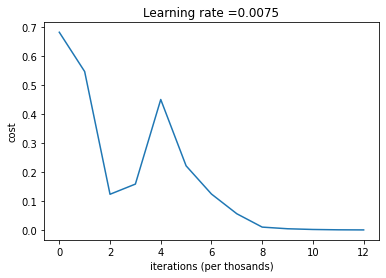

In [846]:
model1.fit()

In [847]:
model1.predict(Xtr,Ytr)

Accuracy: 1.0


In [848]:
model1.predict(Xts,Yts)

Accuracy: 0.7


In [849]:
tic = time()
model1.gradient_check()
toc = time()
print('the total time for gradient checking is : ' + str(round((toc-tic)/60,2)) + ' minutes')

There is a mistake in the backward propagation! difference = 0.9711944765006614
the total time for gradient checking is : 38.73 minutes


**Note**

* Gradient Checking is slow! Approximating the gradient with $\frac{\partial J}{\partial \theta} \approx \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon}$ is computationally costly. For this reason, we don't run gradient checking at every iteration during training. Just a few times to check if the gradient is correct.
* Gradient Checking, at least as we've presented it, doesn't work with dropout. You would usually run the gradient check algorithm without dropout to make sure your backprop is correct, then add dropout.
* Gradient checking verifies closeness between the gradients from backpropagation and the numerical approximation of the gradient (computed using forward propagation).
* Gradient checking is slow, so we don't run it in every iteration of training. You would usually run it only to make sure your code is correct, then turn it off and use backprop for the actual learning process.
